In [1]:
import os, sys
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import cv2
import ast
from skimage import io
from skimage.color import gray2rgb
from tqdm import tqdm
from collections import defaultdict

In [ ]:
max_width = 47000
max_height = 23300
width_200 = 44106
height_200 = 20154
x_offset = (max_width - width_200) // 1
y_offset = (max_height - height_200) // 1

In [2]:
HOME = os.path.expanduser("~")
DIR = os.path.join(HOME, 'Projects/pipeline_utility')
sys.path.append(DIR)
from utilities.contour_utilities import get_contours_from_annotations, add_structure_to_neuroglancer, \
    create_full_volume, get_structure_colors
from utilities.imported_atlas_utilities import get_all_structures
color_radius = 3
xy_ng_resolution_um = 5
color_radius = 3
animal = 'MD594'

CSV_PATH = '/net/birdstore/Active_Atlas_Data/data_root/atlas_data/foundation_brain_annotations'
csvfile = os.path.join(CSV_PATH, f'{animal}_annotation.csv')
hand_annotations = pd.read_csv(csvfile)
hand_annotations['vertices'] = hand_annotations['vertices'] \
    .apply(lambda x: x.replace(' ', ','))\
    .apply(lambda x: x.replace('\n',','))\
    .apply(lambda x: x.replace(',]',']'))\
    .apply(lambda x: x.replace(',,', ','))\
    .apply(lambda x: x.replace(',,', ','))\
    .apply(lambda x: x.replace(',,', ',')).apply(lambda x: x.replace(',,', ','))

hand_annotations['vertices'] = hand_annotations['vertices'].apply(lambda x: ast.literal_eval(x))

Connecting dklab@db.dk.ucsd.edu:3306


In [3]:
structures = list(hand_annotations['name'].unique())
section_structure_vertices = defaultdict(dict)
for structure in tqdm(structures):
    contour_annotations, first_sec, last_sec = get_contours_from_annotations(animal, structure, hand_annotations, densify=4)
    for section in contour_annotations:
        section_structure_vertices[section][structure] = contour_annotations[section][structure][1]

100%|██████████| 65/65 [00:07<00:00,  9.13it/s]


In [4]:
section_images = {}
thumbnail_dir = f'/net/birdstore/Active_Atlas_Data/data_root/pipeline_data/{animal}/preps/CH1/thumbnail'
for file_name in tqdm(sorted(os.listdir(thumbnail_dir))):
    filepath = os.path.join(thumbnail_dir, file_name)
    img = io.imread(filepath)
    section = int(file_name.split('.')[0])
    
    for structure in section_structure_vertices[section]:
        pts = section_structure_vertices[section][structure]
        points = np.array(pts,dtype=np.int32)
        points = points // 32
        cv2.polylines(img, [points], isClosed=True, color=(0,0,0), thickness=2)

#     for structure in structures:
#         contour_annotations, first_sec, last_sec = get_contours_from_annotations(animal, structure, hand_annotations, densify=4)
        
#         if section in contour_annotations:
#             pts = contour_annotations[section][structure][1]
#             points = np.array(pts,dtype=np.int32)
#             points = points // 32
#             cv2.polylines(img, [points], isClosed=True, color=(0,0,0), thickness=2)
    section_images[section] = img

100%|██████████| 433/433 [00:06<00:00, 67.85it/s] 


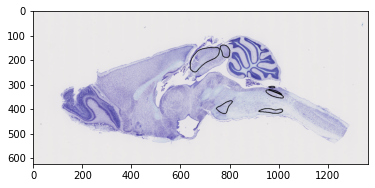

In [5]:
section = 222
plt.imshow(section_images[section], cmap="gray")
plt.show()

In [14]:
OUTPUT = os.path.join(HOME, 'Desktop', 'tmp')
os.makedirs(OUTPUT, exist_ok=True)
for section in tqdm(section_images):
    outpath = os.path.join(OUTPUT, f'{section}.tif')
    cv2.imwrite(outpath, section_images[section])

100%|██████████| 433/433 [00:09<00:00, 47.82it/s]
